In [1]:
!git clone https://github.com/viswambhar-yasa/image_captioning

Cloning into 'image_captioning'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 61 (delta 28), reused 17 (delta 6), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [2]:
cd /content/image_captioning

/content/image_captioning


In [3]:
from data_extraction import downloading_extraction

In [4]:
images_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
downloading_extraction(images_link)
text_link = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
downloading_extraction(text_link)

In [5]:
from model_networks import Caption_model_gen
from data_processing import data_processing

In [6]:
import tensorflow as tf

In [7]:
value_model = Caption_model_gen(NET='value', vocab_size=8360, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
83697664/83683744 [==============================] - 0s 0us/step
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {concat shape}: (None, 1024)
output {shape} (None, 1)
Value Net built successfully 



In [8]:
value_model.summary()

Model: "Value_Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                         

In [9]:
cd /content/image_captioning

/content/image_captioning


In [10]:
captions_path=r"/content/image_captioning/Flickr8k.token.txt"

In [11]:
text = open(captions_path, 'r', encoding='utf-8').read()
description_map=dict()
for lines in text.split('\n'):
  line_split = lines.split('\t')
  if line_split == ['']:
      continue
  image_id = line_split[0][:-2]
  image_des = line_split[1]
  #if image_id in img_dic:
  if image_id not in description_map:
    description_map[image_id] = list()
  description_map[image_id].append(image_des)
caption_list = []
for img_id, des_list in description_map.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        caption = ''.join(caption)
        caption = caption.split(' ')
        caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
        caption = ' '.join(caption)
        des_list[i] = 'startseq ' + caption + ' endseq'
        caption_list.append('startseq ' + caption + ' endseq')
max_length = max(len(des.split()) for des in caption_list)
print('max_length of captions', max_length)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

max_length of captions 33


In [12]:
import os
files=os.listdir(path = '/content/image_captioning/Flicker8k_Dataset')

In [13]:
description_map1=dict()
for key,value in description_map.items():
  if key in files:
    description_map1[key]=value

In [14]:
token_cap_dic = dict()
print('Vocab size',len(tokenizer.word_counts))
for img_id, des_list in description_map1.items():
    for i in range(len(des_list)):
        caption = des_list[i]
        cap_token = tokenizer.texts_to_sequences([str(caption)])
        if img_id not in token_cap_dic:
            token_cap_dic[img_id] = list()
        token_cap_dic[img_id].append(cap_token)

Vocab size 8359


In [28]:
from model_losses import loss,Rewards,cos
from data_processing import data_processing
from data_generator import captions_generation_reward,load_preprocess_img

In [17]:
import pickle

print('TensorFlow Version', tf.__version__)
vocab_size = 8360
max_length = 15

captions_text_path = r'/content/image_captioning/Flickr8k.token.txt'
captions_extraction = data_processing(captions_text_path)
trn_images_id_text = r'/content/image_captioning/Flickr_8k.trainImages.txt'
train_cleaned_seq, train_cleaned_dic = captions_extraction.cleaning_sequencing_captions(trn_images_id_text)
val_images_id_text = r'/content/image_captioning/Flickr_8k.devImages.txt'
val_cleaned_seq, val_cleaned_dic = captions_extraction.cleaning_sequencing_captions(val_images_id_text)
test_images_id_text = r'/content/image_captioning/Flickr_8k.testImages.txt'
test_cleaned_seq, test_cleaned_dic = captions_extraction.cleaning_sequencing_captions(test_images_id_text)
captions_extraction.tokenization(train_cleaned_seq, vocab_size)
print("No of captions: Training-" + str(len(train_cleaned_seq) / 5) + " Validation-" + str(
    len(val_cleaned_seq) / 5) + " test-" + str(len(test_cleaned_seq) / 5))

train_cap_tok = captions_extraction.sentence_tokenizing(train_cleaned_dic)
val_cap_tok = captions_extraction.sentence_tokenizing(val_cleaned_dic)
test_cap_tok = captions_extraction.sentence_tokenizing(test_cleaned_dic)

image_pth_rt = r"/content/image_captioning/Flicker8k_Dataset/" #+ r"\\"
trn_dataset = captions_generation_reward(train_cap_tok, vocab_size, image_pth_rt, 25,5,1)
val_dataset = captions_generation_reward(val_cap_tok, vocab_size, image_pth_rt, 25,32,1)

inputs = next(iter(trn_dataset))
print(inputs[0].shape, inputs[1].shape)

TensorFlow Version 2.8.0
max_length of captions 33
max_length of captions 31
max_length of captions 30
No of captions: Training-6000.0 Validation-1000.0 test-1000.0
Vocab size 8360
Vocab size 8360
Vocab size 8360
(5, 256, 256, 3) (5, 25)


In [30]:
import numpy as np

In [32]:
def caption_greedy(policy_net,image,tokenizer,word_index,max_length=25):
  caption='startseq'
  for i in range(max_length):
    input_seq=caption.split(' ')
    tokenization=tokenizer.texts_to_sequences(input_seq)
    padding=tf.keras.preprocessing.sequence.pad_sequences([tokenization],maxlen=max_length) 
    predicted_word_index=np.argmax(policy_net.predict([tf.expand_dims(image,axis=0),padding]))
    predicted_word=word_index[predicted_word_index]
    caption+=' '+predicted_word
    if predicted_word =='endseq':
      break
  return caption

In [18]:
actor_model = Caption_model_gen(NET='policy', vocab_size=8360, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {add shape}: (None, 512)
output {shape} (None, 8360)
Policy Net built successfully 



In [ ]:
actor_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_resnet_lstm.h5')

In [19]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8360,oov_token='<unknw>')
tokenizer.fit_on_texts(caption_list)

In [20]:
word_index=tokenizer.word_index
word_index={value:key for key, value in word_index.items()}

In [21]:
import matplotlib.pyplot as plt

In [22]:
trn_dataset_whole = captions_generation_reward(token_cap_dic, vocab_size, image_pth_rt, max_length=25,num_photos_per_batch=32,num_captions=5)

In [23]:
reward_model = Caption_model_gen(NET='reward', vocab_size=8360, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image feature vector shape: (None, 512)
Text sequence vector shape: (None, 512)
Reward Net built successfully 



In [ ]:
reward_model.load_weights('/content/drive/MyDrive/Kaggle/policy_net_weights_xception_lstm.h5')

OSError: ignored

In [24]:
value_model = Caption_model_gen(NET='value', vocab_size=8360, Embed_Size=512, max_length=25,display=True)
#actor_model.summary()
#reward_model.compile(loss=reward_net_loss,                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                    metrics=['accuracy'])

Building CNN model
CNN model {output shape}: (None, 2048)
Building RNN model
final_carry_state {rnn output shape}: (None, 512)
Image and text {concat shape}: (None, 1024)
output {shape} (None, 1)
Value Net built successfully 



In [25]:
inputs = next(iter(trn_dataset))

In [26]:
r=Rewards(reward_model,inputs)
print(r)

tf.Tensor([-0.01990153  0.0207907   0.02579585  0.0624245  -0.02776499], shape=(5,), dtype=float32)


tf.Tensor([0.00576186], shape=(1,), dtype=float32)


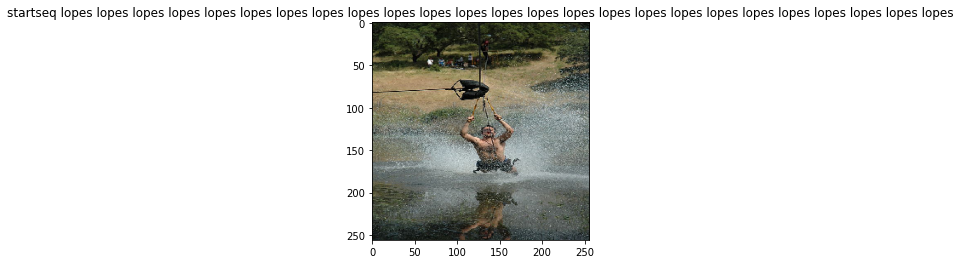

In [33]:
test_img=list(test_cap_tok.keys())[50]
test_photo = load_preprocess_img(image_pth_rt + test_img)
cap=caption_greedy(actor_model,test_photo,tokenizer,word_index)
plt.imshow(test_photo)
plt.title(cap)
tokenization=tokenizer.texts_to_sequences([cap])
seq_cap=tf.keras.preprocessing.sequence.pad_sequences(tokenization, maxlen=25,
                                                                            padding='post')
input_ds=[tf.expand_dims(test_photo,axis=0),seq_cap]
reward=Rewards(reward_model,input_ds)
print(reward)

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
history={}
history['loss']=list()
history['val_loss']=list()
metrics_names = ['loss'] 
epochs = 1
num_epoch=100
for i in range(epochs):
    n=0
    epoch=0
    for step, x_batch_train in enumerate(trn_dataset):
        if epoch==num_epoch:
          break
        progbar = tf.keras.utils.Progbar(10,stateful_metrics=['loss'])
        with tf.GradientTape() as tape:
            input_image=x_batch_train[0]
            input_seq=x_batch_train[1][:,:np.random.randint(5)]
            input_padseq=tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=25,
                                                                            padding='post')
            input_batch=[input_image,input_padseq]
            value = value_model(x_batch_train, training=True)  
            reward=Rewards(reward_model,x_batch_train)
            loss_value = tf.keras.losses.mean_squared_error(value,reward)

        grads = tape.gradient(loss_value, value_model.trainable_weights)

        optimizer.apply_gradients(zip(grads, value_model.trainable_weights))
        progbar.update(n, values = [("loss", loss_value)])
        n+=1
        if step % 10 == 0:
            epoch+=1
            val_ds=next(iter(val_dataset))
            val_value = value_model(val_ds)
            
            val_reward=Rewards(reward_model,val_ds)
           
            val_loss_value=tf.keras.losses.mean_squared_error(val_value,val_reward)
            progbar.add(1,values = [("val_loss", val_loss_value)])
            n=0
            print(val_value.numpy()[0],val_reward.numpy()[0])
            print("\nepoch %d" % (epoch,))
            history['loss'].append(loss_value)
            history['val_loss'].append(val_loss_value)

 1/10 [==>...........................] - ETA: 8s - loss: 0.3650 - val_loss: 0.3955[-0.52751297] -0.013290568

epoch 1
10/10 [==============================] - 1s 86ms/step - loss: 0.0988 - val_loss: 0.0797
[-0.27494407] 0.06548306

epoch 2
10/10 [==============================] - 1s 86ms/step - loss: 0.2247 - val_loss: 0.1560
[-0.39741147] 0.03835158

epoch 3
10/10 [==============================] - 1s 83ms/step - loss: 0.0174 - val_loss: 0.0837
[0.03669123] 0.0056708613

epoch 4
10/10 [==============================] - 1s 84ms/step - loss: 0.0514 - val_loss: 0.0554
[-0.00439673] -0.00087823195

epoch 5
10/10 [==============================] - 1s 82ms/step - loss: 0.0201 - val_loss: 0.0445
[0.07702664] 0.021296864

epoch 6
10/10 [==============================] - 1s 85ms/step - loss: 0.0409 - val_loss: 0.0782
[0.4489065] -0.025615947

epoch 7
10/10 [==============================] - 1s 85ms/step - loss: 0.0276 - val_loss: 0.0469
[-0.24169679] 0.05456323

epoch 8
10/10 [================

In [ ]:
f = open("/content/history_value_model_3_layer_adam.pkl", "wb")
pickle.dump(history, f)
f.close() 